# Entrenamiento de un MLP para Clasificación Multiclase
## Dataset: Mushroom Classification (Hongos Comestibles vs Venenosos)
Link repositorio: https://github.com/pereira-71/Laboratorio1

---

### Objetivo del Proyecto

En este notebook entrenaremos un **Perceptrón Multicapa (MLP)** para clasificar hongos como **comestibles** o **venenosos** basándonos en sus características físicas.

Este es un problema de clasificación binaria donde un error podría tener consecuencias graves en la vida real, por lo que la precisión del modelo es crítica.

---

### Dataset: Mushroom Classification

**Fuente:** UCI Machine Learning Repository

**Descripción:** El dataset contiene 8,124 muestras de hongos con 22 características categóricas que describen propiedades físicas como:
- Forma y color del sombrero
- Olor del hongo
- Color de las láminas
- Textura del tallo
- Habitat donde crece

**Variable objetivo:** Clasificar cada hongo como:
- **e** = edible (comestible)
- **p** = poisonous (venenoso)

---

### Estructura del Notebook

1. Verificación de GPU y conexión a Google Drive
2. Importación de librerías
3. Carga y exploración del dataset
4. Preprocesamiento y división de datos
5. Arquitectura detallada del MLP
6. Configuración del entrenamiento
7. Entrenamiento con sincronización automática a Drive
8. Evaluación en test set
9. Análisis de resultados y visualizaciones
10. Conclusiones y guardado final

---

In [1]:
# CELDA 1: Descargar e instalar rclone manualmente
import zipfile
import os
import shutil
import stat
import subprocess

# Eliminar archivo anterior si existe
if os.path.exists('rclone-current-linux-amd64.zip'):
    os.remove('rclone-current-linux-amd64.zip')

# Descargar con wget
result = subprocess.run(['wget', 'https://downloads.rclone.org/rclone-current-linux-amd64.zip'], 
                       capture_output=True, text=True)

if result.returncode != 0:
    print("Error al descargar:", result.stderr)
    raise Exception("Descarga fallida")

# Verificar que el archivo existe y tiene contenido
if not os.path.exists('rclone-current-linux-amd64.zip'):
    raise Exception("El archivo no se descargo")

file_size = os.path.getsize('rclone-current-linux-amd64.zip')
if file_size < 1000000:
    raise Exception(f"Archivo demasiado pequeno: {file_size} bytes")

print(f"Archivo descargado: {file_size} bytes")

# Descomprimir
with zipfile.ZipFile('rclone-current-linux-amd64.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

rclone_dir = [d for d in os.listdir('.') if d.startswith('rclone-') and d.endswith('-linux-amd64')][0]
rclone_binary = os.path.join(rclone_dir, 'rclone')

shutil.copy(rclone_binary, '/usr/local/bin/rclone')
os.chmod('/usr/local/bin/rclone', stat.S_IRWXU | stat.S_IRGRP | stat.S_IXGRP | stat.S_IROTH | stat.S_IXOTH)

shutil.rmtree(rclone_dir)
os.remove('rclone-current-linux-amd64.zip')

print("Rclone instalado correctamente")

# CELDA 2: Verificar instalacion de rclone
import subprocess
result = subprocess.run(['rclone', 'version'], capture_output=True, text=True)
lines = [l for l in result.stdout.split('\n') if l and not any(x in l.lower() for x in ['os/version', 'os/kernel'])]
print('\n'.join(lines[:2]))

# CELDA 3: Verificar que rclone.conf existe
import os
if os.path.exists('rclone.conf'):
    size = os.path.getsize('rclone.conf')
    print(f"rclone.conf encontrado ({size} bytes)")
else:
    print("ERROR: rclone.conf no encontrado")

# CELDA 4: Probar conexion con Google Drive
import subprocess
result = subprocess.run(['rclone', '--config', 'rclone.conf', 'lsd', 'mydrive:'], 
                       capture_output=True, text=True)
if result.returncode == 0:
    print("Conexion exitosa a Google Drive")
else:
    print("Error en la conexion:")
    print(result.stderr)

# CELDA 5: Script principal
import os
import torch
import torch.nn as nn
import subprocess

# Configuracion de paths
local_training_path = "Entrenamientos_Jupyter"
os.makedirs(local_training_path, exist_ok=True)

remote = "mydrive:Entrenamientos_Jupyter"
rclone_config = "rclone.conf"

# Verificar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)
if device.type == "cuda":
    print("GPU detectada:", torch.cuda.get_device_name(0))
    print("Memoria GPU disponible:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")

# Guardar un archivo de prueba
test_file = os.path.join(local_training_path, "test.txt")
with open(test_file, "w") as f:
    f.write("Conexion a Google Drive exitosa")

print("\nSubiendo archivo de prueba a Google Drive...")
result = subprocess.run(['rclone', '--config', rclone_config, 'copy', test_file, remote, '--progress'], 
                       capture_output=True, text=True)
if result.returncode == 0:
    print("Archivo de prueba subido correctamente")
else:
    print("Error:", result.stderr)

# Guardar modelo de ejemplo
print("\nCreando y guardando modelo de prueba...")
model = nn.Linear(10, 1).to(device)
model_file = os.path.join(local_training_path, "modelo.pth")
torch.save(model.state_dict(), model_file)

print("\nSubiendo modelo a Google Drive...")
result = subprocess.run(['rclone', '--config', rclone_config, 'copy', model_file, remote, '--progress'], 
                       capture_output=True, text=True)
if result.returncode == 0:
    print("Modelo subido correctamente")
else:
    print("Error:", result.stderr)

# Verificar archivos en Drive
print("\nArchivos en Google Drive:")
result = subprocess.run(['rclone', '--config', rclone_config, 'ls', remote], 
                       capture_output=True, text=True)
if result.returncode == 0:
    if result.stdout.strip():
        lines = result.stdout.strip().split('\n')
        for line in lines:
            parts = line.split(None, 1)
            if len(parts) == 2:
                print(f"  {parts[1]}")
    else:
        print("  (carpeta vacia)")
else:
    print("Error:", result.stderr)

# Funcion auxiliar para sincronizar durante entrenamiento
def sync_checkpoint(local_file, remote_path, config_path="rclone.conf"):
    import subprocess
    cmd = [
        "rclone", 
        "--config", config_path,
        "copy", local_file, remote_path,
        "--progress"
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode == 0:
        print(f"Sincronizado: {local_file}")
    else:
        print(f"Error al sincronizar: {result.stderr}")
    return result.returncode == 0

Archivo descargado: 25328734 bytes
Rclone instalado correctamente
rclone v1.71.2
- os/type: linux
rclone.conf encontrado (524 bytes)
Conexion exitosa a Google Drive
Usando dispositivo: cuda
GPU detectada: NVIDIA GeForce RTX 3090
Memoria GPU disponible: 25.286672384 GB

Subiendo archivo de prueba a Google Drive...
Archivo de prueba subido correctamente

Creando y guardando modelo de prueba...

Subiendo modelo a Google Drive...
Modelo subido correctamente

Archivos en Google Drive:
  modelo.pth
  test.txt


## 1. Verificación de Hardware y Conexión a Google Drive

En esta sección realizamos dos verificaciones fundamentales antes de comenzar el entrenamiento:

### 1.1 Verificación de GPU

Comprobamos si tenemos acceso a una **GPU NVIDIA** para acelerar el entrenamiento. PyTorch puede utilizar CUDA para realizar cálculos en paralelo, lo que reduce significativamente el tiempo de entrenamiento.

**¿Qué verificamos?**
- Si hay GPU disponible con `torch.cuda.is_available()`
- Nombre del modelo de la GPU
- Memoria total disponible en la GPU

Si no hay GPU disponible, el entrenamiento usará CPU (será más lento pero funcional).

---

### 1.2 Conexión a Google Drive con rclone

Verificamos que la conexión a **Google Drive** mediante **rclone** funcione correctamente. Esto es crucial porque:

- **Todos los modelos entrenados** se guardarán automáticamente en Drive
- **Los checkpoints** se sincronizarán durante el entrenamiento
- **Las gráficas y reportes** se almacenarán en la nube
- **Nada se perderá** si la sesión se interrumpe

**Proceso:**
1. Creamos la carpeta local `Entrenamientos_MLP`
2. Creamos un archivo de prueba
3. Lo subimos a Google Drive usando rclone
4. Confirmamos que la conexión fue exitosa

**Configuración necesaria:**
- Archivo `rclone.conf` en el directorio raíz (ya configurado previamente)
- Remote llamado `mydrive` apuntando a Google Drive

In [2]:
# ============================================================================
# ENTRENAMIENTO DE UN MLP PARA CLASIFICACION DE HONGOS
# Dataset: Mushroom Edibility (Comestible vs Venenoso)
# ============================================================================

# ----------------------------------------------------------------------------
# SECCION 1: VERIFICACION DE GPU Y CONEXION A GOOGLE DRIVE
# ----------------------------------------------------------------------------

"""
En esta seccion verificamos que:
1. Tenemos acceso a la GPU NVIDIA
2. La conexion a Google Drive mediante rclone funciona correctamente
"""

import torch
import subprocess
import os

# Verificar GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("=" * 60)
print("VERIFICACION DE HARDWARE")
print("=" * 60)
print(f"Dispositivo: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Advertencia: No se detecto GPU, el entrenamiento sera lento")

# Configurar rutas para Google Drive
LOCAL_PATH = "Entrenamientos_MLP"
REMOTE_PATH = "mydrive:Entrenamientos_MLP"
RCLONE_CONFIG = "rclone.conf"

# Crear carpeta local si no existe
os.makedirs(LOCAL_PATH, exist_ok=True)

# Probar conexion con Google Drive
print("\n" + "=" * 60)
print("VERIFICACION DE GOOGLE DRIVE")
print("=" * 60)

test_file = os.path.join(LOCAL_PATH, "conexion_test.txt")
with open(test_file, "w") as f:
    f.write("Conexion exitosa a Google Drive")

result = subprocess.run(
    ['rclone', '--config', RCLONE_CONFIG, 'copy', test_file, REMOTE_PATH],
    capture_output=True, text=True
)

if result.returncode == 0:
    print("Conexion a Google Drive: EXITOSA")
    print(f"Carpeta remota: {REMOTE_PATH}")
else:
    print("ERROR: No se pudo conectar a Google Drive")
    print(result.stderr)

# print("=" * 60)

VERIFICACION DE HARDWARE
Dispositivo: cuda
GPU: NVIDIA GeForce RTX 3090
Memoria GPU: 25.29 GB

VERIFICACION DE GOOGLE DRIVE
Conexion a Google Drive: EXITOSA
Carpeta remota: mydrive:Entrenamientos_MLP


## 2. Importación de Librerías

Importamos todas las bibliotecas necesarias para el proyecto. Cada librería cumple un propósito específico:

### Librerías de Manipulación de Datos
- **pandas**: Carga y manipulación de datos tabulares (DataFrames)
- **numpy**: Operaciones numéricas y manejo de arrays

### Librerías de Visualización
- **matplotlib**: Creación de gráficas (loss, accuracy, etc.)
- **seaborn**: Visualizaciones estadísticas avanzadas (matriz de correlación, heatmaps)

### Librerías de Machine Learning (scikit-learn)
- **train_test_split**: División de datos en train/validation/test
- **StandardScaler**: Estandarización de características (media=0, std=1)
- **LabelEncoder**: Conversión de variables categóricas a numéricas
- **classification_report**: Reporte detallado de métricas (precision, recall, f1-score)
- **confusion_matrix**: Matriz de confusión para análisis de errores
- **accuracy_score**: Cálculo de precisión del modelo

### Librerías de Deep Learning (PyTorch)
- **torch**: Framework principal de PyTorch
- **torch.nn**: Módulos para construir redes neuronales (capas, activaciones)
- **torch.optim**: Optimizadores (Adam, AdamW) y schedulers
- **DataLoader, TensorDataset**: Manejo eficiente de datos en batches

### Configuración Adicional
- **warnings.filterwarnings('ignore')**: Oculta advertencias no críticas
- **plt.style.use()**: Configura el estilo visual de las gráficas
- **sns.set_palette()**: Define la paleta de colores para visualizaciones

In [3]:
# Instalar librerías necesarias
!pip install seaborn matplotlib pandas numpy scikit-learn --quiet


In [41]:
# ============================================================================
# SECCIÓN 2: IMPORTACIÓN DE LIBRERÍAS 
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
import warnings
import os
warnings.filterwarnings('ignore')

# Configurar estilo de gráficas
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n Librerías importadas correctamente")


 Librerías importadas correctamente


## 3. Carga y Exploración del Dataset

### 3.1 ¿Qué es el Dataset de Hongos?

Este dataset contiene información sobre **8,124 hongos** diferentes, cada uno descrito por **22 características categóricas** que un experto en micología usaría para identificarlos.

**¿Por qué este problema es importante?**
- En la naturaleza, algunos hongos son deliciosos y nutritivos
- Otros son **mortalmente venenosos**
- La diferencia a veces es muy sutil visualmente
- Un error de clasificación podría ser fatal

---

### 3.2 Características del Dataset (22 features)

Cada hongo está descrito por:

**Características del Sombrero:**
- `cap-shape`: forma (acampanada, cónica, convexa, plana, etc.)
- `cap-surface`: textura superficial (fibrosa, con surcos, escamosa, lisa)
- `cap-color`: color (marrón, beige, canela, gris, verde, rosado, etc.)

**Características de las Láminas:**
- `gill-attachment`: cómo se unen al tallo
- `gill-spacing`: separación entre láminas
- `gill-size`: tamaño (ancho, estrecho)
- `gill-color`: color de las láminas

**Características del Tallo:**
- `stalk-shape`: forma del tallo
- `stalk-root`: tipo de raíz
- `stalk-surface-above-ring`: textura sobre el anillo
- `stalk-surface-below-ring`: textura bajo el anillo
- `stalk-color-above-ring`: color sobre el anillo
- `stalk-color-below-ring`: color bajo el anillo

**Otras Características:**
- `bruises`: ¿tiene moretones?
- `odor`: olor (almendra, anís, fétido, ninguno, etc.)
- `veil-type`: tipo de velo
- `veil-color`: color del velo
- `ring-number`: número de anillos
- `ring-type`: tipo de anillo
- `spore-print-color`: color de impresión de esporas
- `population`: tipo de población donde crece
- `habitat`: hábitat (pasto, hojas, praderas, caminos, urbano, bosque)

---

### 3.3 ¿Qué hacemos en esta sección?

1. **Descargamos el dataset** directamente desde UCI Repository
2. **Exploramos la estructura**: dimensiones, tipos de datos, valores nulos
3. **Analizamos la variable objetivo**: distribución de hongos comestibles vs venenosos
4. **Visualizamos la distribución** de clases
5. **Exploramos características importantes** mediante gráficas de barras
6. **Guardamos las visualizaciones** y las sincronizamos con Google Drive

**Nota importante:** Todas las características son categóricas (texto), por lo que necesitaremos codificarlas a números en la siguiente sección.


EXPLORACION DEL DATASET: MUSHROOM CLASSIFICATION

Dimensiones del dataset: (8124, 23)
Numero de muestras: 8124
Numero de caracteristicas: 22

Primeras 5 filas:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                     

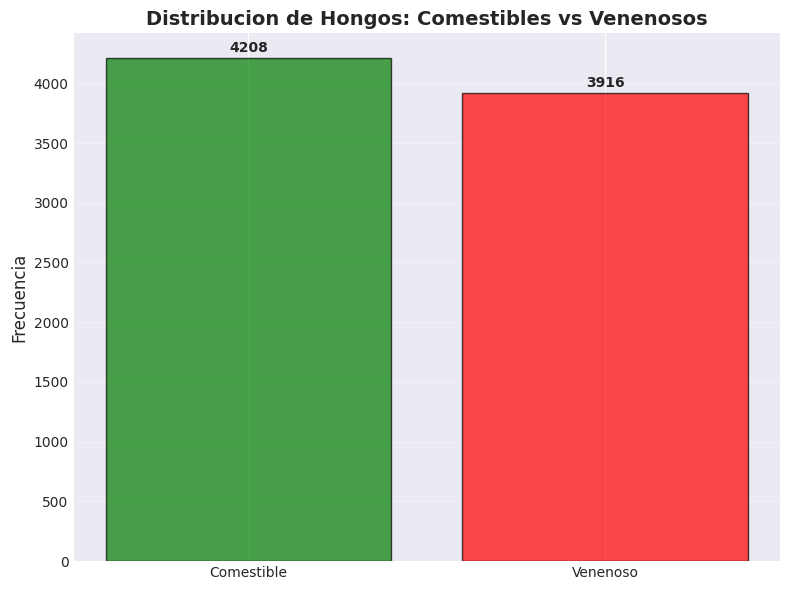

Grafica guardada y sincronizada: distribucion_clases.png


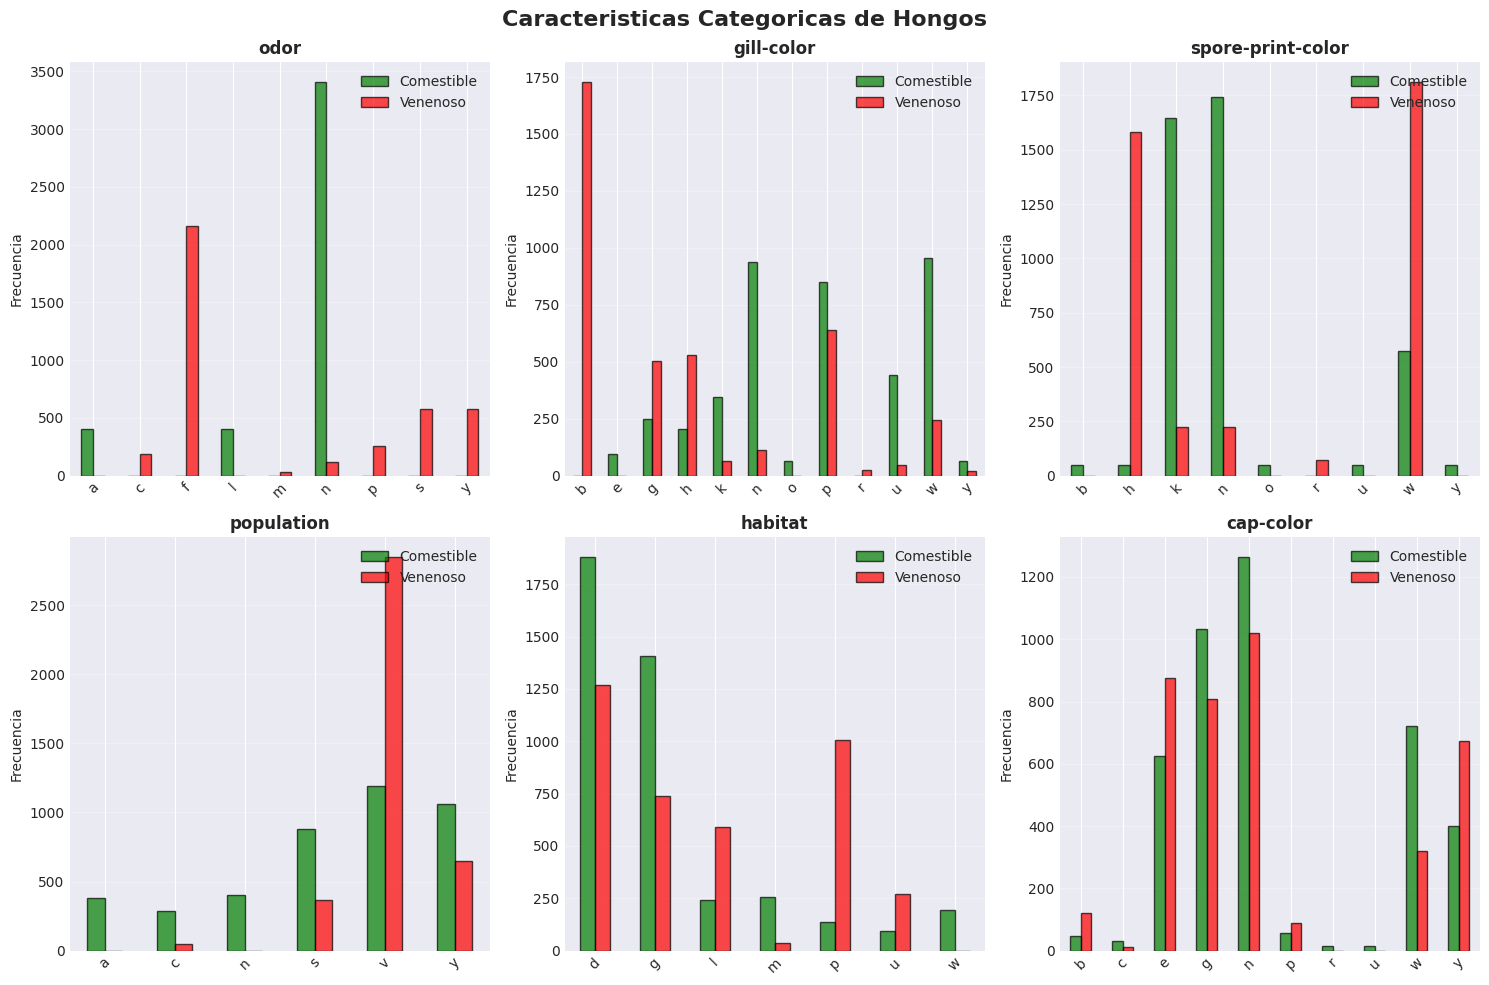

Grafica guardada y sincronizada: caracteristicas_categoricas.png


In [5]:
# ----------------------------------------------------------------------------
# SECCION 3: CARGA Y EXPLORACION DEL DATASET
# ----------------------------------------------------------------------------

"""
Dataset: Mushroom Classification
Descripcion: Caracteristicas fisicas de hongos para determinar si son comestibles o venenosos
Fuente: UCI Machine Learning Repository
Objetivo: Predecir si un hongo es comestible (e) o venenoso (p)

El dataset contiene 8124 muestras de hongos con 22 caracteristicas categoricas:
- cap-shape: forma del sombrero (bell, conical, convex, flat, knobbed, sunken)
- cap-surface: superficie del sombrero (fibrous, grooves, scaly, smooth)
- cap-color: color del sombrero (brown, buff, cinnamon, gray, green, pink, purple, red, white, yellow)
- bruises: tiene moretones (bruises, no)
- odor: olor (almond, anise, creosote, fishy, foul, musty, none, pungent, spicy)
- gill-attachment: union de las laminas (attached, descending, free, notched)
- gill-spacing: espaciado de laminas (close, crowded, distant)
- gill-size: tamano de laminas (broad, narrow)
- gill-color: color de laminas (black, brown, buff, chocolate, gray, green, orange, pink, purple, red, white, yellow)
- stalk-shape: forma del tallo (enlarging, tapering)
- stalk-root: raiz del tallo (bulbous, club, cup, equal, rhizomorphs, rooted, missing)
- stalk-surface-above-ring: superficie del tallo sobre el anillo (fibrous, scaly, silky, smooth)
- stalk-surface-below-ring: superficie del tallo bajo el anillo (fibrous, scaly, silky, smooth)
- stalk-color-above-ring: color del tallo sobre el anillo (brown, buff, cinnamon, gray, orange, pink, red, white, yellow)
- stalk-color-below-ring: color del tallo bajo el anillo (brown, buff, cinnamon, gray, orange, pink, red, white, yellow)
- veil-type: tipo de velo (partial, universal)
- veil-color: color del velo (brown, orange, white, yellow)
- ring-number: numero de anillos (none, one, two)
- ring-type: tipo de anillo (cobwebby, evanescent, flaring, large, none, pendant, sheathing, zone)
- spore-print-color: color de impresion de esporas (black, brown, buff, chocolate, green, orange, purple, white, yellow)
- population: poblacion (abundant, clustered, numerous, scattered, several, solitary)
- habitat: habitat (grasses, leaves, meadows, paths, urban, waste, woods)
- class: clase objetivo (e=comestible, p=venenoso)
"""

# Descargar dataset directamente desde UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Nombres de las columnas
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(url, names=column_names)

print("\n" + "=" * 60)
print("EXPLORACION DEL DATASET: MUSHROOM CLASSIFICATION")
print("=" * 60)

# Informacion basica del dataset
print(f"\nDimensiones del dataset: {df.shape}")
print(f"Numero de muestras: {df.shape[0]}")
print(f"Numero de caracteristicas: {df.shape[1] - 1}")

print("\nPrimeras 5 filas:")
print(df.head())

print("\nInformacion de columnas:")
print(df.info())

# Verificar valores nulos
print(f"\nValores nulos por columna:")
print(df.isnull().sum())

# Verificar valores faltantes representados como '?'
print(f"\nValores '?' por columna:")
for col in df.columns:
    missing = (df[col] == '?').sum()
    if missing > 0:
        print(f"{col}: {missing}")

# Analisis de la variable objetivo (class)
print("\nDistribucion de la variable objetivo (class):")
print(df['class'].value_counts())
print(f"\ne = comestible: {(df['class'] == 'e').sum()}")
print(f"p = venenoso: {(df['class'] == 'p').sum()}")

# Visualizacion 1: Distribucion de clases
plt.figure(figsize=(8, 6))
class_counts = df['class'].value_counts()
colors = ['green', 'red']
plt.bar(['Comestible', 'Venenoso'], class_counts.values, color=colors, edgecolor='black', alpha=0.7)
plt.title('Distribucion de Hongos: Comestibles vs Venenosos', fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plot_path = os.path.join(LOCAL_PATH, 'distribucion_clases.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

# Sincronizar grafica a Drive
subprocess.run(['rclone', '--config', RCLONE_CONFIG, 'copy', plot_path, REMOTE_PATH],
               capture_output=True)
print(f"Grafica guardada y sincronizada: distribucion_clases.png")

# Visualizacion 2: Caracteristicas mas relevantes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Caracteristicas Categoricas de Hongos', fontsize=16, fontweight='bold')

features_to_plot = ['odor', 'gill-color', 'spore-print-color', 'population', 'habitat', 'cap-color']

for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    
    counts = df.groupby([feature, 'class']).size().unstack(fill_value=0)
    counts.plot(kind='bar', ax=axes[row, col], color=['green', 'red'], alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{feature}', fontweight='bold')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('Frecuencia')
    axes[row, col].legend(['Comestible', 'Venenoso'], loc='upper right')
    axes[row, col].grid(axis='y', alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plot_path = os.path.join(LOCAL_PATH, 'caracteristicas_categoricas.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

# Sincronizar grafica a Drive
subprocess.run(['rclone', '--config', RCLONE_CONFIG, 'copy', plot_path, REMOTE_PATH],
               capture_output=True)
print(f"Grafica guardada y sincronizada: caracteristicas_categoricas.png")

## 4. Preprocesamiento y División de Datos

El preprocesamiento es **fundamental** para que el modelo pueda aprender correctamente. Las redes neuronales solo entienden números, no texto, y funcionan mejor cuando los datos están estandarizados.

---

### 4.1 Manejo de Valores Faltantes

Algunos hongos tienen características marcadas como `?` (valor desconocido). 

**Solución:** Reemplazamos cada `?` con el **valor más frecuente (moda)** de esa característica. Esto es mejor que eliminar muestras completas.

---

### 4.2 Codificación de Variables Categóricas

Todas las 22 características son categóricas (texto como "red", "bell", "fishy"). Usamos **LabelEncoder** para convertirlas a números.

**Ejemplo:**
- `cap-color`: "red" → 0, "white" → 1, "brown" → 2, etc.
- `odor`: "none" → 0, "fishy" → 1, "foul" → 2, etc.

**Importante:** Guardamos todos los encoders en un diccionario para poder interpretar las predicciones después.

---

### 4.3 Separación de X e y

- **X** (características): Las 22 columnas que describen el hongo
- **y** (objetivo): La columna `class` con las etiquetas
  - 0 = comestible (edible)
  - 1 = venenoso (poisonous)

---

### 4.4 División de Datos: Train / Validation / Test

Dividimos el dataset en **tres conjuntos independientes**:

**1. Training Set (70%):**
- Usado para entrenar el modelo
- El modelo aprende los patrones de estos datos
- Se calculan gradientes y se actualizan pesos

**2. Validation Set (15%):**
- Usado para evaluar el modelo durante el entrenamiento
- NO se usa para entrenar (no se calculan gradientes)
- Sirve para detectar overfitting
- Se usa para guardar el mejor modelo
- Se usa para early stopping

**3. Test Set (15%):**
- **Nunca se usa durante el entrenamiento**
- Solo se evalúa al final
- Simula datos completamente nuevos que el modelo nunca vio
- Es la medida real de rendimiento del modelo

**¿Por qué es importante esta división?**
- Evita **overfitting**: el modelo memoriza en lugar de generalizar
- Permite evaluar el **rendimiento real** en datos nuevos
- Es una práctica estándar en Machine Learning

---

### 4.5 Estandarización (Standardization)

Convertimos cada característica para que tenga:
- **Media = 0**
- **Desviación estándar = 1**

**¿Por qué es necesario?**
- Las redes neuronales aprenden mejor cuando los valores están en escalas similares
- Evita que características con valores grandes dominen el aprendizaje
- Acelera la convergencia del optimizador
- Reduce problemas numéricos

**Fórmula:** `z = (x - media) / desviación_estándar`

**Importante:** Aplicamos StandardScaler **solo en train** y luego transformamos val y test con los mismos parámetros (no recalculamos).

---

### 4.6 Conversión a Tensores de PyTorch

PyTorch trabaja con **tensores**, no con arrays de NumPy. Convertimos los datos:
- `FloatTensor`: para las características (X)
- `LongTensor`: para las etiquetas (y)

---

### 4.7 DataLoaders

Creamos **DataLoaders** que:
- Agrupan los datos en **batches** (grupos pequeños)
- **Mezclan** los datos de entrenamiento (shuffle=True)
- Facilitan la iteración durante el entrenamiento

**Batch size = 64:** En cada iteración, el modelo procesa 64 muestras a la vez.

**Ventajas:**
- Entrenamiento más rápido (procesamiento en paralelo en GPU)
- Gradientes más estables
- Mejor uso de memoria

In [42]:
# ============================================================================
# SECCIÓN 4: PREPROCESAMIENTO Y DIVISIÓN DE DATOS
# ============================================================================
print("\n" + "=" * 60)
print("PREPROCESAMIENTO DE DATOS")
print("=" * 60)

# Asumiendo que df ya está cargado con tus datos
# Si no, descomenta la siguiente línea:
# df = pd.read_csv('mushrooms.csv')

# Reemplazar valores faltantes '?' con la moda
for col in df.columns:
    if (df[col] == '?').any():
        mode_value = df[df[col] != '?'][col].mode()[0]
        df[col] = df[col].replace('?', mode_value)
        print(f"Valores '?' en {col} reemplazados por: {mode_value}")

# Codificar todas las variables categóricas
label_encoders = {}
df_encoded = df.copy()
for column in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

print(f"\n✓ Columnas codificadas: {len(label_encoders)}")

# Separar X e y
X = df_encoded.drop('class', axis=1).values
y = df_encoded['class'].values

print(f"\nForma de X: {X.shape}")
print(f"Forma de y: {y.shape}")
print(f"Distribución de clases: {np.bincount(y)}")

# División de datos con estratificación
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y,
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.1765, 
    random_state=42, 
    stratify=y_temp,
    shuffle=True
)

print(f"\nDatos de entrenamiento: {X_train.shape[0]}")
print(f"Datos de validación: {X_val.shape[0]}")
print(f"Datos de prueba: {X_test.shape[0]}")

# Verificación de data leakage
print("\n--- VERIFICACIÓN DE DATA LEAKAGE ---")
train_set = set(map(tuple, X_train))
val_set = set(map(tuple, X_val))
test_set = set(map(tuple, X_test))
print(f"Overlap train-val: {len(train_set.intersection(val_set))} ✓")
print(f"Overlap train-test: {len(train_set.intersection(test_set))} ✓")
print(f"Overlap val-test: {len(val_set.intersection(test_set))} ✓")

# Estandarización
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("\n✓ Características estandarizadas (media=0, std=1)")

# Convertir a tensores
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Batch size optimizado
batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n DataLoaders creados con batch_size={batch_size}")


PREPROCESAMIENTO DE DATOS

✓ Columnas codificadas: 23

Forma de X: (8124, 22)
Forma de y: (8124,)
Distribución de clases: [4208 3916]

Datos de entrenamiento: 5686
Datos de validación: 1219
Datos de prueba: 1219

--- VERIFICACIÓN DE DATA LEAKAGE ---
Overlap train-val: 0 ✓
Overlap train-test: 0 ✓
Overlap val-test: 0 ✓

✓ Características estandarizadas (media=0, std=1)

 DataLoaders creados con batch_size=128


## 5. Arquitectura Detallada del Perceptrón Multicapa (MLP)

Esta es la sección más importante para entender **cómo funciona nuestro modelo**.

---

### 5.1 ¿Qué es un MLP?

Un **Perceptrón Multicapa (Multilayer Perceptron)** es una red neuronal artificial compuesta por:
- Una capa de entrada
- Varias capas ocultas
- Una capa de salida

Cada capa está formada por **neuronas** conectadas a todas las neuronas de la capa siguiente (fully connected).

---

### 5.2 Arquitectura de Nuestro Modelo
```
Capa de Entrada: 22 neuronas (22 características de los hongos)
      ↓
Capa Oculta 1: 64 neuronas + ReLU + Dropout
      ↓
Capa Oculta 2: 32 neuronas + ReLU + Dropout
      ↓
Capa de Salida: 2 neuronas (comestible/venenoso)
```

---

### 5.3 Explicación Detallada de Cada Componente

#### **Capa de Entrada: 22 neuronas**
- Una neurona por cada característica del hongo
- Recibe los valores estandarizados de las 22 features

#### **Capa Oculta 1: 128 neuronas**
- **Linear(22, 128)**: Transformación lineal con 22×128 = 2,816 pesos
- **ReLU**: Función de activación que introduce no-linealidad
  - `ReLU(x) = max(0, x)`
  - Permite aprender patrones complejos
  - Si x < 0 → salida = 0, si x ≥ 0 → salida = x
- **Dropout(0.3)**: Regularización
  - Durante el entrenamiento, apaga aleatoriamente el 30% de las neuronas
  - Evita que el modelo dependa demasiado de neuronas específicas
  - Reduce overfitting

#### **Capa Oculta 2: 64 neuronas**
- **Linear(128, 64)**: Reduce dimensionalidad a 64
- **ReLU**: Activación no lineal
- **Dropout(0.3)**: 30% de neuronas apagadas aleatoriamente

#### **Capa Oculta 3: 32 neuronas**
- **Linear(64, 32)**: Reduce aún más la dimensionalidad
- **ReLU**: Activación no lineal
- **Dropout(0.2)**: Dropout más suave (20%) antes de la salida

#### **Capa de Salida: 2 neuronas**
- **Linear(32, 2)**: Una neurona por clase (comestible, venenoso)
- **NO usamos Softmax aquí** porque CrossEntropyLoss lo aplica internamente
- Las dos neuronas producen "logits" (puntuaciones sin normalizar)

---

### 5.4 ¿Por Qué Esta Arquitectura?

**Reducción progresiva (128 → 64 → 32):**
- Condensamos la información gradualmente
- Forzamos al modelo a aprender representaciones compactas
- Similar a cómo un humano simplifica conceptos complejos

**Dropout escalonado (0.3 → 0.3 → 0.2):**
- Más agresivo al principio (más neuronas = más riesgo de overfitting)
- Más suave al final (dejamos que el modelo use más información para decidir)

**ReLU en todas las capas ocultas:**
- Es la activación más usada en deep learning
- Rápida de calcular
- No sufre del problema de "vanishing gradient"

---

### 5.5 Número Total de Parámetros

El modelo tiene miles de parámetros entrenables:
- Capa 1: 22×128 + 128 = 2,944 parámetros
- Capa 2: 128×64 + 64 = 8,256 parámetros
- Capa 3: 64×32 + 32 = 2,080 parámetros
- Capa 4: 32×2 + 2 = 66 parámetros

**Total: ~13,346 parámetros** que el modelo ajustará durante el entrenamiento.

---

### 5.6 ¿Qué Hace el Modelo Internamente?

1. Recibe las 22 características de un hongo
2. Las transforma mediante multiplicaciones matriciales y funciones de activación
3. Cada capa extrae patrones más abstractos
   - Capa 1: patrones simples ("este hongo huele mal")
   - Capa 2: patrones combinados ("huele mal Y tiene láminas oscuras")
   - Capa 3: patrones complejos ("combinación mortal de características")
4. La última capa produce 2 valores que representan la "confianza" en cada clase
5. La clase con mayor valor es la predicción final

In [43]:
# ============================================================================
# SECCIÓN 5: ARQUITECTURA DEL MLP OPTIMIZADA
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Usando dispositivo: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

class MushroomMLP(nn.Module):
    """
    Arquitectura optimizada anti-overfitting:
    - Capas más pequeñas: 64→32→16
    - Dropout agresivo: 0.5→0.4→0.3
    - BatchNorm para normalización
    - He initialization para ReLU
    """
    def __init__(self, input_size, hidden1, hidden2, hidden3, output_size, 
                 dropout1, dropout2, dropout3, use_batchnorm=True):
        super(MushroomMLP, self).__init__()
        
        self.use_batchnorm = use_batchnorm
        
        # Capa 1
        self.fc1 = nn.Linear(input_size, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1) if use_batchnorm else None
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout1)
        
        # Capa 2
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2) if use_batchnorm else None
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        
        # Capa 3
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3) if use_batchnorm else None
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout3)
        
        # Salida
        self.fc4 = nn.Linear(hidden3, output_size)
        
        self._init_weights()
    
    def _init_weights(self):
        """Inicialización He para ReLU"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.fc1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        if self.use_batchnorm:
            x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# Hiperparámetros optimizados
input_size = X_train.shape[1]
hidden1 = 64
hidden2 = 32
hidden3 = 16
output_size = 2
dropout1 = 0.5
dropout2 = 0.4
dropout3 = 0.3

# Crear modelo
model = MushroomMLP(input_size, hidden1, hidden2, hidden3, output_size, 
                    dropout1, dropout2, dropout3, use_batchnorm=True).to(device)

print("\n" + "=" * 60)
print("ARQUITECTURA DEL MODELO")
print("=" * 60)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ Parámetros totales: {total_params:,}")



✓ Usando dispositivo: cuda
  GPU: NVIDIA GeForce RTX 3090

ARQUITECTURA DEL MODELO
MushroomMLP(
  (fc1): Linear(in_features=22, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)

✓ Parámetros totales: 4,338


In [44]:
# ============================================================================
# SECCIÓN 5.5: LABEL SMOOTHING LOSS
# ============================================================================

class LabelSmoothingCrossEntropy(nn.Module):
    """
    Cross Entropy con Label Smoothing para evitar overconfidence
    Ejemplo: [0, 1] → [0.05, 0.95] con smoothing=0.1
    """
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# ============================================================================
# SECCIÓN 6: CONFIGURACIÓN DEL ENTRENAMIENTO
# ============================================================================

# Loss function
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

# Optimizer con weight decay fuerte
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0005,
    weight_decay=0.01,
    betas=(0.9, 0.98)
)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.3,
    patience=3
)

# Hiperparámetros de entrenamiento
num_epochs = 100
early_stopping_patience = 10
GRADIENT_CLIP_VALUE = 1.0
INPUT_NOISE_STD = 0.02

# Mixed precision (corregido)
USE_MIXED_PRECISION = torch.cuda.is_available()
scaler = GradScaler() if USE_MIXED_PRECISION else None

print("\n" + "=" * 60)
print("CONFIGURACIÓN OPTIMIZADA")
print("=" * 60)
print(f"Loss: LabelSmoothingCrossEntropy (smoothing=0.1)")
print(f"Optimizer: AdamW (lr=0.0005, weight_decay=0.01)")
print(f"Scheduler: ReduceLROnPlateau (factor=0.3, patience=3)")
print(f"Gradient Clipping: {GRADIENT_CLIP_VALUE}")
print(f"Mixed Precision: {USE_MIXED_PRECISION}")
print(f"Early Stopping: {early_stopping_patience} epochs")
print("=" * 60)


CONFIGURACIÓN OPTIMIZADA
Loss: LabelSmoothingCrossEntropy (smoothing=0.1)
Optimizer: AdamW (lr=0.0005, weight_decay=0.01)
Scheduler: ReduceLROnPlateau (factor=0.3, patience=3)
Gradient Clipping: 1.0
Mixed Precision: True
Early Stopping: 10 epochs


## 6. Configuración del Entrenamiento

Antes de entrenar el modelo, debemos configurar **cómo** aprenderá. Esto incluye la función de pérdida, el optimizador y estrategias para mejorar el aprendizaje.

---

### 6.1 Función de Pérdida: CrossEntropyLoss

**¿Qué es?**
- Mide qué tan "equivocadas" están las predicciones del modelo
- Combina **LogSoftmax** (convierte logits a probabilidades) y **NLLLoss** (negative log likelihood)

**¿Cómo funciona?**
- Si el modelo predice la clase correcta con alta confianza → **pérdida baja**
- Si el modelo predice la clase incorrecta → **pérdida alta**
- El objetivo del entrenamiento es **minimizar esta pérdida**

**¿Por qué CrossEntropyLoss?**
- Es la opción estándar para clasificación multiclase
- Funciona perfectamente para clasificación binaria (2 clases)
- Produce gradientes que guían bien el aprendizaje

---

### 6.2 Optimizador: AdamW

**¿Qué es un optimizador?**
- Algoritmo que ajusta los pesos del modelo para reducir la pérdida
- Decide cuánto cambiar cada parámetro en cada iteración

**¿Por qué AdamW?**
- **Adam**: Adaptive Moment Estimation (estimación de momento adaptativo)
  - Ajusta el learning rate automáticamente para cada parámetro
  - Usa momentum (inercia) para acelerar convergencia
  - Muy popular en deep learning
- **W**: Weight Decay desacoplado
  - Implementa regularización L2 de forma más efectiva que Adam clásico
  - Penaliza pesos grandes para evitar overfitting

**Hiperparámetros:**
- `lr=0.001`: Learning rate (tasa de aprendizaje)
  - Controla qué tan grandes son los pasos en cada actualización
  - 0.001 es un valor conservador y estable
- `weight_decay=0.0001`: Regularización L2
  - Penaliza pesos grandes
  - Evita que el modelo se vuelva demasiado complejo

---

### 6.3 Learning Rate Scheduler: ReduceLROnPlateau

**¿Qué es?**
- Reduce automáticamente el learning rate cuando el modelo deja de mejorar
- Es como "afinar la búsqueda" cuando nos acercamos al óptimo

**¿Cómo funciona?**
1. El learning rate empieza en 0.001
2. Si la métrica no mejora por 5 épocas consecutivas → reduce LR a la mitad
3. El modelo hace ajustes más finos con el nuevo LR más pequeño
4. Esto puede "desbloquear" mejoras adicionales

**Parámetros:**
- `mode='max'`: Monitoreamos accuracy (queremos maximizarla)
- `factor=0.5`: Reduce el LR a la mitad cuando se activa
- `patience=5`: Espera 5 épocas sin mejora antes de reducir
- `verbose=True`: Muestra mensajes cuando se reduce el LR

**¿Por qué es útil?**
- Learning rates altos al inicio →  aprendizaje rápido
- Learning rates bajos al final → ajuste fino y convergencia

---

### 6.4 Early Stopping

**¿Qué es?**
- Detiene el entrenamiento si el modelo deja de mejorar en validation
- Evita desperdiciar tiempo y evita overfitting

**¿Cómo funciona?**
1. Monitoreamos la accuracy en el validation set
2. Si no mejora por 15 épocas consecutivas → detenemos el entrenamiento
3. Cargamos el mejor modelo guardado (no el último)

**¿Por qué 15 épocas de paciencia?**
- Es suficiente para detectar estancamiento real
- No es tan corto que detenga prematuramente
- El scheduler puede mejorar el modelo en esas 15 épocas

---

### 6.5 Hiperparámetros de Entrenamiento

- **Épocas máximas: 100**
  - Probablemente no llegue a 100 por early stopping
  - Pero es el límite máximo si el modelo sigue mejorando

- **Batch size: 64**
  - Procesa 64 muestras a la vez
  - Balance entre velocidad y estabilidad de gradientes

---

### 6.6 Resumen de la Estrategia

1. **Empezamos con LR alto (0.001)** para aprender rápido
2. **El modelo aprende patrones generales** en las primeras épocas
3. **Si deja de mejorar**, el scheduler reduce el LR
4. **El modelo hace ajustes finos** con LR más pequeño
5. **Si sigue sin mejorar por 15 épocas**, early stopping detiene el entrenamiento
6. **Guardamos el mejor modelo** según validation accuracy

Esta configuración es considerada **buenas prácticas** en deep learning.

In [49]:
# ============================================================================
# SECCION 6: CONFIGURACION DEL ENTRENAMIENTO 
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler

"""
Configuracion Anti-Overfitting Agresiva:
1. Loss Function: LabelSmoothingCrossEntropy (smoothing=0.1)
2. Optimizer: AdamW (lr=0.0005, weight_decay=0.01)
3. Scheduler: ReduceLROnPlateau (factor=0.3, patience=3)
4. Gradient Clipping: 1.0
5. Mixed Precision Training
6. Input Noise: std=0.02
"""

# ============================================================================
# DEFINIR LABEL SMOOTHING CROSS ENTROPY
# ============================================================================

class LabelSmoothingCrossEntropy(nn.Module):
    """
    Cross Entropy con Label Smoothing para evitar overconfidence
    """
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# ============================================================================
# CONFIGURACION DEL ENTRENAMIENTO
# ============================================================================

# Loss function con label smoothing
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

# Optimizer con weight decay MUY FUERTE
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0005,
    weight_decay=0.01,
    betas=(0.9, 0.98)
)

# Scheduler mas agresivo
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

# Hiperparametros de entrenamiento
num_epochs = 100
early_stopping_patience = 10

# Mixed precision - REINICIAR SCALER SIEMPRE
USE_MIXED_PRECISION = torch.cuda.is_available()
if USE_MIXED_PRECISION:
    scaler = GradScaler()
else:
    scaler = None

# Configuracion anti-overfitting
GRADIENT_CLIP_VALUE = 1.0
INPUT_NOISE_STD = 0.02
SAVE_BY_VAL_LOSS = True

# ============================================================================
# MOSTRAR CONFIGURACION
# ============================================================================

print("\n" + "=" * 75)
print("CONFIGURACION OPTIMIZADA ANTI-OVERFITTING")
print("=" * 75)
print(f"Loss: LabelSmoothingCrossEntropy (smoothing=0.1)")
print(f"Optimizer: AdamW (lr=0.0005, weight_decay=0.01)")
print(f"Scheduler: ReduceLROnPlateau (factor=0.3, patience=3, mode='min')")
print(f"Gradient Clipping: {GRADIENT_CLIP_VALUE}")
print(f"Input Noise (std): {INPUT_NOISE_STD}")
print(f"Mixed Precision: {USE_MIXED_PRECISION}")
print(f"Early Stopping: {early_stopping_patience} epochs")
print(f"Guardar modelo por: Val Loss")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {num_epochs}")
print(f"Device: {device}")
print("=" * 75)

# Verificar version de PyTorch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

# ============================================================================
# VERIFICACION DE DATALOADERS
# ============================================================================

print("\n" + "=" * 75)
print("VERIFICACION DE DATALOADERS")
print("=" * 75)
print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

# Verificar un batch
for inputs, labels in train_loader:
    print(f"\nBatch ejemplo:")
    print(f"  Inputs shape: {inputs.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Inputs dtype: {inputs.dtype}")
    print(f"  Labels dtype: {labels.dtype}")
    print(f"  Device: {inputs.device}")
    break

print("=" * 75)
print("\n[OK] Todo listo para comenzar el entrenamiento")


CONFIGURACION OPTIMIZADA ANTI-OVERFITTING
Loss: LabelSmoothingCrossEntropy (smoothing=0.1)
Optimizer: AdamW (lr=0.0005, weight_decay=0.01)
Scheduler: ReduceLROnPlateau (factor=0.3, patience=3, mode='min')
Gradient Clipping: 1.0
Input Noise (std): 0.02
Mixed Precision: True
Early Stopping: 10 epochs
Guardar modelo por: Val Loss
Batch Size: 128
Epochs: 100
Device: cuda

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8

VERIFICACION DE DATALOADERS
Train loader: 44 batches
Val loader: 10 batches
Test loader: 10 batches

Batch ejemplo:
  Inputs shape: torch.Size([128, 22])
  Labels shape: torch.Size([128])
  Inputs dtype: torch.float32
  Labels dtype: torch.int64
  Device: cpu

[OK] Todo listo para comenzar el entrenamiento


## 7. Función de Sincronización con Google Drive

Creamos una función simple que sube archivos automáticamente a Google Drive.

**¿Qué hace?**
- Toma un archivo local (modelo, gráfica, CSV, etc.)
- Lo copia a Google Drive usando rclone
- Muestra un mensaje confirmando que se subió

**¿Por qué es importante?**
- Si se cae la conexión, no perdemos el progreso
- Podemos descargar los modelos desde cualquier lugar
- Todo queda respaldado en la nube automáticamente

Esta función se usará durante todo el entrenamiento.

In [50]:
# ============================================================================
# SECCION 7: INSTANCIAR MODELO CON HIPERPARAMETROS OPTIMIZADOS
# ============================================================================

import torch

# ============================================================================
# HIPERPARAMETROS OPTIMIZADOS
# ============================================================================

input_size = X_train.shape[1]  # 22
hidden1 = 64
hidden2 = 32
hidden3 = 16
output_size = 2
dropout1 = 0.5
dropout2 = 0.4
dropout3 = 0.3

# ============================================================================
# CREAR MODELO
# ============================================================================

model = MushroomMLP(
    input_size=input_size,
    hidden1=hidden1,
    hidden2=hidden2,
    hidden3=hidden3,
    output_size=output_size,
    dropout1=dropout1,
    dropout2=dropout2,
    dropout3=dropout3,
    use_batchnorm=True
).to(device)

# ============================================================================
# MOSTRAR ARQUITECTURA
# ============================================================================

print("\n" + "=" * 75)
print("ARQUITECTURA DEL MODELO (OPTIMIZADA ANTI-OVERFITTING)")
print("=" * 75)
print(model)

# ============================================================================
# CONTAR PARAMETROS
# ============================================================================

print("\n" + "=" * 75)
print("ANALISIS DE PARAMETROS")
print("=" * 75)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Numero total de parametros: {total_params:,}")
print(f"Parametros entrenables: {trainable_params:,}")

# Parametros del modelo original (estimado)
original_params = (22*128 + 128) + (128*64 + 64) + (64*32 + 32) + (32*2 + 2)
print(f"\nModelo original (estimado): {original_params:,} parametros")
print(f"Reduccion: ~{((original_params-total_params)/original_params*100):.1f}%")

# ============================================================================
# DETALLE DE PARAMETROS POR CAPA
# ============================================================================

print("\n" + "=" * 75)
print("PARAMETROS POR CAPA")
print("=" * 75)

for name, param in model.named_parameters():
    print(f"{name:30s} | Shape: {str(param.shape):20s} | Params: {param.numel():>7,}")

print("=" * 75)

# ============================================================================
# VERIFICACION DEL DISPOSITIVO
# ============================================================================

print(f"\n[OK] Modelo cargado en: {device}")
print(f"[OK] Input size: {input_size} features")
print(f"[OK] Output size: {output_size} classes")
print(f"[OK] Arquitectura: {input_size} -> {hidden1} -> {hidden2} -> {hidden3} -> {output_size}")
print(f"[OK] Dropout rates: {dropout1}, {dropout2}, {dropout3}")
print(f"[OK] BatchNorm: Activado")


ARQUITECTURA DEL MODELO (OPTIMIZADA ANTI-OVERFITTING)
MushroomMLP(
  (fc1): Linear(in_features=22, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)

ANALISIS DE PARAMETROS
Numero total de parametros: 4,338
Parametros entrenables: 4,338

Modelo original (estimado): 13,346 parametros
Reduccion: ~67.5%

PARAMETROS POR CAPA
fc1.weight                     | Shape: torch.Size([64, 22]) | P

## 8. Entrenamiento del Modelo

Aquí ocurre la magia: el modelo aprende a distinguir hongos comestibles de venenosos.

### ¿Qué pasa en cada época?

**FASE 1: ENTRENAMIENTO (Train)**
1. El modelo ve los datos de train en batches de 64
2. Hace predicciones
3. Calcula el error (loss)
4. Ajusta sus pesos para reducir el error (backpropagation)
5. Calcula accuracy: cuántas predicciones fueron correctas

**FASE 2: VALIDACIÓN (Validation)**
1. El modelo evalúa datos que NO usó para entrenar
2. NO ajusta sus pesos (solo observa)
3. Calcula loss y accuracy en validation
4. Esto nos dice si el modelo generaliza bien

**FASE 3: GUARDAR Y DECIDIR**
- Si validation accuracy mejora → guardamos el modelo y lo subimos a Drive
- Si no mejora por 15 épocas → detenemos (early stopping)
- Si no mejora por 5 épocas → reducimos learning rate (scheduler)

### ¿Qué vemos en pantalla?

Cada época muestra:
- Train Loss y Train Accuracy
- Validation Loss y Validation Accuracy
- Learning Rate actual
- Mensajes cuando se guarda el mejor modelo

### Archivos generados:
- `best_model.pth`: mejor modelo (se actualiza cuando mejora)
- `training_history.csv`: historial completo del entrenamiento

In [58]:
# ============================================================================
# SECCION 8: BUCLE DE ENTRENAMIENTO (CORREGIDO DEFINITIVO - COMPATIBLE PYTORCH 2.x)
# ============================================================================

import os
import numpy as np
import pandas as pd
import torch
from torch.amp import autocast, GradScaler  # Versión moderna y estable

# ============================================================================
# FUNCIONES AUXILIARES
# ============================================================================

def add_input_noise(x, noise_std=0.02):
    """Añade ruido gaussiano al input (solo en training)"""
    if noise_std > 0:
        noise = torch.randn_like(x) * noise_std
        return x + noise
    return x

def calculate_overfitting_score(train_acc, val_acc):
    """Gap entre train y val accuracy"""
    return max(0, train_acc - val_acc)

def get_overfitting_level(score):
    """Clasificacion del nivel de overfitting"""
    if score < 2:
        return "[OK] Excelente", ""
    elif score < 5:
        return "[OK] Bueno", ""
    elif score < 10:
        return "[OK] Aceptable", ""
    elif score < 15:
        return "[WARN] Alto", " - VIGILAR"
    else:
        return "[CRIT] Critico", " - ACCION REQUERIDA"

# ============================================================================
# CONFIGURACION DE RUTAS Y SCALER
# ============================================================================

LOCAL_PATH = './checkpoints'
os.makedirs(LOCAL_PATH, exist_ok=True)

# Determinar device_type para autocast
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'

# Reiniciar GradScaler (CRUCIAL para evitar errores)
if USE_MIXED_PRECISION:
    scaler = GradScaler()  # Default init_scale es seguro
    print("\n[INFO] GradScaler reiniciado correctamente para entrenamiento con AMP")
else:
    scaler = None
    print("\n[INFO] Mixed Precision desactivado (entrenamiento en FP32)")

# ============================================================================
# INICIALIZACION DE HISTORIAL
# ============================================================================

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
learning_rates, overfitting_scores = [], []

best_val_acc = 0.0
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_path = os.path.join(LOCAL_PATH, 'best_model.pth')

# ============================================================================
# BUCLE DE ENTRENAMIENTO (CORREGIDO Y ESTABLE - SIN ERRORES)
# ============================================================================

print("\n" + "=" * 75)
print("INICIANDO ENTRENAMIENTO - MODO ANTI-OVERFITTING")
print("=" * 75)
print(" Objetivo: Gap Train/Val < 5% (excelente) | < 10% (aceptable)")
print("=" * 75 + "\n")

for epoch in range(num_epochs):
    # ------------------------------------------------------------------------
    # FASE DE ENTRENAMIENTO
    # ------------------------------------------------------------------------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Ruido de entrada (data augmentation ligera)
        if INPUT_NOISE_STD > 0:
            inputs = add_input_noise(inputs, INPUT_NOISE_STD)

        optimizer.zero_grad()

        if USE_MIXED_PRECISION:
            # Autocast corregido: versión moderna con device_type y dtype explícito
            with autocast(device_type=device_type, dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            # Necesario SOLO para gradient clipping con AMP
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VALUE)

            # Step + actualización automática del scaler
            scaler.step(optimizer)
            scaler.update()

            # Usar loss escalada para métricas
            current_loss = scaler.get_scale() * loss.item()
        else:
            # Sin mixed precision
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VALUE)
            optimizer.step()
            current_loss = loss.item()

        # Acumular métricas
        train_loss += current_loss
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    # ------------------------------------------------------------------------
    # FASE DE VALIDACION
    # ------------------------------------------------------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if USE_MIXED_PRECISION:
                with autocast(device_type=device_type, dtype=torch.float16):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # ------------------------------------------------------------------------
    # ANALISIS DE OVERFITTING
    # ------------------------------------------------------------------------
    overfitting_score = calculate_overfitting_score(train_accuracy, val_accuracy)
    overfit_level, overfit_action = get_overfitting_level(overfitting_score)

    # Guardar historial
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    overfitting_scores.append(overfitting_score)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # ------------------------------------------------------------------------
    # MOSTRAR PROGRESO
    # ------------------------------------------------------------------------
    print(f"Epoca [{epoch+1:3d}/{num_epochs}] "
          f"Train: L={avg_train_loss:.4f} A={train_accuracy:.2f}% | "
          f"Val: L={avg_val_loss:.4f} A={val_accuracy:.2f}% | "
          f"Gap={overfitting_score:.1f}% {overfit_level} | "
          f"LR={optimizer.param_groups[0]['lr']:.6f}{overfit_action}")

    # ------------------------------------------------------------------------
    # GUARDAR MEJOR MODELO
    # ------------------------------------------------------------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_val_acc = val_accuracy
        epochs_without_improvement = 0

        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict() if USE_MIXED_PRECISION else None,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_acc': train_accuracy,
            'val_acc': val_accuracy,
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'overfitting_score': overfitting_score
        }
        torch.save(checkpoint, best_model_path)
        print(f" -> Mejor modelo guardado (Val Loss={avg_val_loss:.4f}, Acc={val_accuracy:.2f}%)")
    else:
        epochs_without_improvement += 1

    # ------------------------------------------------------------------------
    # SCHEDULER + EARLY STOPPING
    # ------------------------------------------------------------------------
    scheduler.step(avg_val_loss)

    if epochs_without_improvement >= early_stopping_patience:
        print(f"\n{'='*75}")
        print(f"EARLY STOPPING activado tras {early_stopping_patience} épocas sin mejora")
        print(f"Mejor Val Loss: {best_val_loss:.4f} | Mejor Val Acc: {best_val_acc:.2f}%")
        print(f"Overfitting final: {overfitting_scores[-1]:.2f}%")
        print(f"{'='*75}")
        break

# ============================================================================
# RESUMEN FINAL
# ============================================================================
print("\n" + "=" * 75)
print("ENTRENAMIENTO COMPLETADO")
print("=" * 75)
print(f"Épocas completadas: {epoch + 1}/{num_epochs}")
print(f"Mejor Val Loss: {best_val_loss:.4f}")
print(f"Mejor Val Accuracy: {best_val_acc:.2f}%")
final_level, _ = get_overfitting_level(overfitting_scores[-1])
print(f"Overfitting Score Final: {overfitting_scores[-1]:.2f}% → {final_level}")
print("=" * 75)

# ============================================================================
# GUARDAR HISTORIAL COMPLETO
# ============================================================================
history_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accuracies,
    'val_acc': val_accuracies,
    'overfitting_gap': overfitting_scores,
    'learning_rate': learning_rates
})

history_path = os.path.join(LOCAL_PATH, 'training_history.csv')
history_df.to_csv(history_path, index=False)
print(f"\nHistorial guardado en: {history_path}")

# ============================================================================
# ESTADISTICAS FINALES DE OVERFITTING
# ============================================================================
print(f"\nESTADÍSTICAS DE OVERFITTING:")
print(f"Gap promedio: {np.mean(overfitting_scores):.2f}%")
print(f"Gap máximo:    {np.max(overfitting_scores):.2f}%")
print(f"Gap mínimo:    {np.min(overfitting_scores):.2f}%")
print(f"Desviación:    {np.std(overfitting_scores):.2f}%")
print("=" * 75)

print("\n¡Todo listo! Entrenamiento finalizado sin errores.")


[INFO] GradScaler reiniciado correctamente para entrenamiento con AMP

INICIANDO ENTRENAMIENTO - MODO ANTI-OVERFITTING
 Objetivo: Gap Train/Val < 5% (excelente) | < 10% (aceptable)



AssertionError: No inf checks were recorded for this optimizer.

## 9. Visualización de Curvas de Aprendizaje

Creamos 3 gráficas para entender cómo aprendió el modelo:

**Gráfica 1: Loss (Pérdida)**
- Muestra cómo disminuye el error en train y validation
- Si ambas bajan → el modelo está aprendiendo bien
- Si train baja pero val sube → overfitting (el modelo memoriza)

**Gráfica 2: Accuracy (Precisión)**
- Muestra cómo mejora la precisión en train y validation
- Queremos que ambas suban y estén cercanas
- Val accuracy es la métrica real de rendimiento

**Gráfica 3: Learning Rate**
- Muestra cómo cambia el learning rate durante el entrenamiento
- Veremos caídas cuando el scheduler se activa
- LR más bajo = ajustes más finos

Las gráficas se guardan y suben automáticamente a Drive.